# Прогнозирование оттока клиентов телеком-провайдера

Задача состоит в том, чтобы заранее определить клиентов, которые с высокой долей вероятности могут перейти к другому оператору.
У нас имеются выгрузки различных сведений о клиентах и используемых ими услугах.

1. Исследовать выгрузки
    1. Определить целевой признак классификации клиентов
2. Предобработать данные
    1. Проверить на дубли
    2. Проверить на пропуски
    3. Проверить на корректность значений
    4. Привести к адекватным типам данных
    5. Проверить диапазоны значений и выбросы
    6. Собрать разрозненные данные в единый набор признаков и обработать возможные пропуски
3. Подготовить признаки к обучению моделей
    1. Создать возможные дополнительные признаки
    2. Удалить ненужные признаки
    3. Обработать категориальные признаки
    4. Провести масштабирование признаков
    5. Разделить подготовленный набор данных на обучающую, валидационную и тестовую выборки
    6. Обработать возможный дисбаланс классов
4. Обучить модели
    1. Определить набор моделей для обучения 
    2. Определить методы подбора гиперпараметров
    3. Обучить модели 
    4. Определить наиболее значимые признаки
    5. Собрать данные по моделям, гиперпараметрам, метрикам и скорости обучения 
5. Проверить лучшие модели на тестовой выборке
6. Сделать выводы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import pairplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

from statsmodels.graphics.correlation import plot_corr
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import lightgbm as lgb
import catboost as cb

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

## Исследование данных

Пробежимся по таблицам и оценим возможные проблемы с данными: выясним реальные типы данных, проверим диапазоны значений, посмотрим уникальные значения категорий, поищем дубликаты.

In [2]:
contract = pd.read_csv('datasets/contract.csv')
internet = pd.read_csv('datasets/internet.csv')
personal = pd.read_csv('datasets/personal.csv')
phone = pd.read_csv('datasets/phone.csv')

### contract

Таблица содержит основные данные контракта клиента. Таблица является опорной и содержит максимум идентификаторов клиентов среди всех файлов.

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Необходимо преобразовывать данные к числовым типам и посмотреть, есть ли пропуски

In [4]:
contract.sample(5, random_state=42)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,1024-GUALD,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.80,24.8
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45
3825,3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1031.7
1807,6910-HADCM,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,76.35,76.35
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3260.1


**Целевой признак в поле EndDate, клиенты, которые уходят, имеют дату окончания контракта**

Проверим таблицу на полные дубликаты строк.

In [5]:
contract.duplicated().sum()

0

Оценим долю положительного класса

In [6]:
(contract['EndDate']!='No').sum()/len(contract)

0.2653698707936959

In [7]:
list(contract['Type'].unique())

['Month-to-month', 'One year', 'Two year']

In [8]:
list(contract['PaymentMethod'].unique())

['Electronic check',
 'Mailed check',
 'Bank transfer (automatic)',
 'Credit card (automatic)']

In [9]:
list(contract['PaperlessBilling'].unique())

['Yes', 'No']

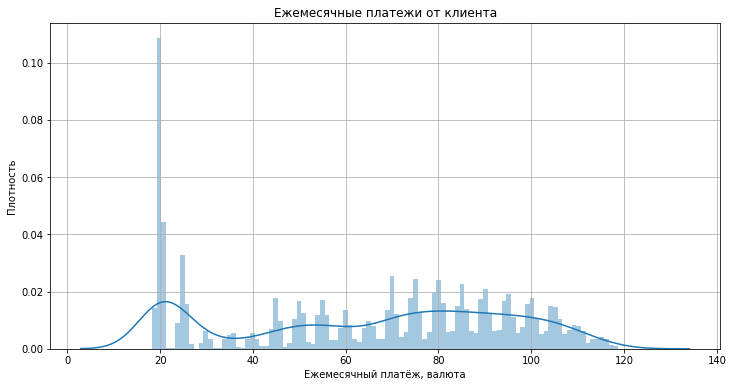

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(contract['MonthlyCharges'].astype(float), bins=100, ax=ax)
ax.set_title('Ежемесячные платежи от клиента')
ax.grid()
ax.set_xlabel("Ежемесячный платёж, валюта")
ax.set_ylabel("Плотность")
plt.show()

In [11]:
list(contract['TotalCharges'].sort_values().head(20))

[' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '100.2',
 '100.25',
 '100.35',
 '100.4',
 '100.8',
 '100.9',
 '1001.2',
 '1001.5',
 '1003.05']

Имеются значения с пробелами

In [12]:
contract[contract['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [13]:
(contract['BeginDate']=='2020-02-01').sum()

11

Можно заменить на нули, так это явно новые абоненты, судя по дате 2020-02-01.

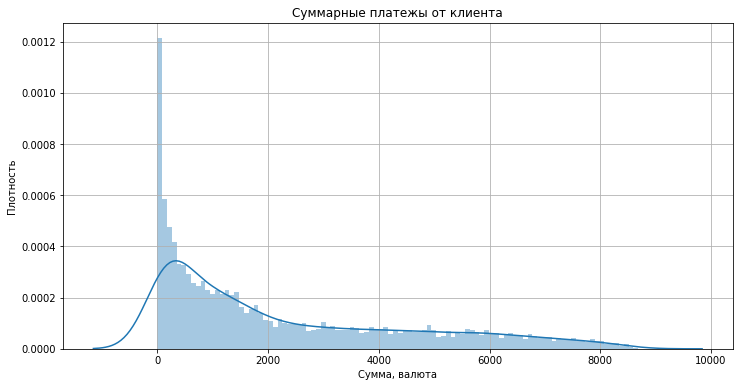

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(contract.replace({'TotalCharges': ' '}, 0)['TotalCharges'].astype(float), bins=100, ax=ax)
ax.set_title('Суммарные платежы от клиента')
ax.grid()
ax.set_xlabel("Сумма, валюта")
ax.set_ylabel("Плотность")
plt.show()

Нулевые значения объясняются новыми клиентами, которые подключились менее месяца до выгрузки данных. Стоит их оставить, чтобы модель понимала, что такие клиенты не являются потенциальными "бегунками".

## personal

Таблица содержит дополнительные данные о клиенте.

In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
personal.duplicated().sum()

0

Здесь также необходимо преобразовывать данные к числовым типам. Пока не видно, есть ли пропуски

In [17]:
personal.sample(5, random_state=42)

,customerID,gender,SeniorCitizen,Partner,Dependents
185,1024-GUALD,Female,0,Yes,No
2715,0484-JPBRU,Male,0,No,No
3825,3620-EHIMZ,Female,0,Yes,Yes
1807,6910-HADCM,Female,0,No,No
132,8587-XYZSF,Male,0,No,No


In [18]:
personal.duplicated().sum()

0

In [19]:
list(personal['gender'].unique())

['Female', 'Male']

In [20]:
list(personal['SeniorCitizen'].unique())

[0, 1]

In [21]:
list(personal['Partner'].unique())

['Yes', 'No']

In [22]:
list(personal['Dependents'].unique())

['No', 'Yes']

## phone

Данные об использовании клиентом телефонной линии.

In [23]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
phone.duplicated().sum()

0

Необходимо преобразовывать типы данных. Данных меньше, чем в опорной таблице

In [25]:
phone.sample(5, random_state=42)

,customerID,MultipleLines
4743,5887-IKKYO,Yes
4825,7718-UPSKJ,No
472,3571-DPYUH,Yes
2722,3769-MHZNV,No
932,6732-FZUGP,Yes


In [26]:
phone.duplicated().sum()

0

In [27]:
list(phone['MultipleLines'].unique())

['No', 'Yes']

## internet

Данные об использовании клиентом подключения к интернету.

In [28]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [29]:
internet.duplicated().sum()

0

Необходимо преобразовывать данные к числовым типам. Данных меньше, чем в опорной таблице, не все пользуются интернетом

In [30]:
internet.sample(5, random_state=42)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1615,1170-SASML,Fiber optic,No,Yes,Yes,No,No,No
1874,9314-QDMDW,DSL,No,Yes,No,No,Yes,No
3167,2434-EEVDB,Fiber optic,Yes,No,Yes,No,Yes,No
5287,7672-VFMXZ,DSL,Yes,No,No,Yes,No,No
4770,7445-WMRBW,DSL,No,Yes,Yes,Yes,Yes,No


Возможно, стоит выделить признак с количеством используемых интернет-услуг вместо или вместе с имеющимися

**Необходимо преобразование типов данных, объединение таблиц и заполнение пропусков. Из дат контрактов возможно вычислить дополнительный признак - длительность контракта. На первый взгляд, данные довольно чистые.**

## Предобработка данных

Обработаем и соберём все данные вместе

In [31]:
df = (
    contract.rename(columns={'customerID': 'CustomerID'})
    .set_index('CustomerID')
    .astype({'MonthlyCharges': float})
    .replace({'TotalCharges': ' '}, 0)
    .astype({'TotalCharges': float})
    .assign( # добавление и вычисление целевого признака (Target)
        Target=lambda x: x.EndDate != 'No'
    )
    #.astype({'Target': int})
    .assign( # приведение к типу date
        BeginDate=lambda x: pd.to_datetime(x['BeginDate'], format='%Y-%m-%d'),
        EndDate=lambda x: pd.to_datetime(x['EndDate'], format='%Y-%m-%d', errors='coerce')
    )
    .fillna(value={'EndDate': pd.to_datetime('2020-02-01', format='%Y-%m-%d')}) # по-умолчанию дата на момент выгрузки
    .assign( # добавление признака "продолжительность использования услуг" (Duration)
        Duration=lambda x: (x['EndDate'] - x['BeginDate']).dt.days) 
    .assign(PaperlessBilling=lambda x: x['PaperlessBilling'] == 'Yes')
    .drop(columns=['BeginDate', 'EndDate']) # удаление дат как слабохарактеризующих признаков
    .join( # personal
        (personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
         .set_index('CustomerID')
         .replace({'Gender': {'Female': False, 'Male': True}})
         .astype({'SeniorCitizen': bool})
         .assign(
            Partner=lambda x: x.Partner == 'Yes',
            Dependents=lambda x: x.Dependents == 'Yes'
         )
        ), how='left')
    .join( # phone
        (phone.rename(columns={'customerID': 'CustomerID'})
         .set_index('CustomerID')
         .assign(
             UsePhone=True,
             MultipleLines=lambda x: x.MultipleLines == 'Yes'
         )
        ), how='left')
    .fillna(value={ # не использующим телефон устанавливаем False
        'MultipleLines': False, 
        'UsePhone': False
    })
    .join( # internet
        (internet.rename(columns={'customerID': 'CustomerID'})
         .set_index('CustomerID')
         .assign( # приведение к типу bool
             OnlineSecurity=lambda x: x['OnlineSecurity'] == 'Yes',
             OnlineBackup=lambda x: x['OnlineBackup'] == 'Yes',
             DeviceProtection=lambda x: x['DeviceProtection'] == 'Yes',
             TechSupport=lambda x: x['TechSupport'] == 'Yes',
             StreamingTV=lambda x: x['StreamingTV'] == 'Yes',
             StreamingMovies=lambda x: x['StreamingMovies'] == 'Yes'
         )
         .assign( # добавление признака "кол-во доп. интернет-услуг" (InternetServicesCount)
             InternetServicesCount=lambda x: x.iloc[:, 1:].sum(axis=1)
         )
        ), how='left')
    .fillna(value={
        'InternetService': 'None',
        'OnlineSecurity': False,
        'OnlineBackup': False,
        'DeviceProtection': False,
        'TechSupport': False,
        'StreamingTV': False,
        'StreamingMovies': False,
        'InternetServicesCount': 0
    })
    .astype({'InternetServicesCount': int})
)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   7043 non-null   object 
 1   PaperlessBilling       7043 non-null   bool   
 2   PaymentMethod          7043 non-null   object 
 3   MonthlyCharges         7043 non-null   float64
 4   TotalCharges           7043 non-null   float64
 5   Target                 7043 non-null   bool   
 6   Duration               7043 non-null   int64  
 7   Gender                 7043 non-null   bool   
 8   SeniorCitizen          7043 non-null   bool   
 9   Partner                7043 non-null   bool   
 10  Dependents             7043 non-null   bool   
 11  MultipleLines          7043 non-null   bool   
 12  UsePhone               7043 non-null   bool   
 13  InternetService        7043 non-null   object 
 14  OnlineSecurity         7043 non-null   bool   

In [33]:
df.sample(10, random_state=42)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,Gender,SeniorCitizen,Partner,...,MultipleLines,UsePhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetServicesCount
CustomerID,,,,,,,,,,,,,,,,,,,,,
1024-GUALD,Month-to-month,True,Electronic check,24.80,24.80,True,31,False,False,True,...,False,False,DSL,False,False,False,False,False,False,0
0484-JPBRU,Month-to-month,True,Bank transfer (automatic),25.25,996.45,False,1248,True,False,False,...,True,True,None,False,False,False,False,False,False,0
3620-EHIMZ,Two year,False,Mailed check,19.35,1031.70,False,1584,False,False,True,...,False,True,None,False,False,False,False,False,False,0
6910-HADCM,Month-to-month,False,Electronic check,76.35,76.35,True,30,False,False,False,...,False,True,Fiber optic,False,False,True,False,False,False,1
8587-XYZSF,Two year,False,Bank transfer (automatic),50.55,3260.10,False,2041,True,False,False,...,False,True,DSL,False,False,False,True,False,False,1
6818-WOBHJ,Month-to-month,True,Bank transfer (automatic),89.60,6127.60,True,2071,False,True,True,...,True,True,Fiber optic,False,True,False,False,False,True,2
3082-YVEKW,Two year,True,Bank transfer (automatic),77.15,1759.40,False,702,False,False,True,...,True,True,DSL,True,False,True,True,True,False,4
4737-AQCPU,Two year,False,Credit card (automatic),72.10,5016.65,False,2191,True,False,True,...,True,True,DSL,True,True,True,True,False,False,4
4853-RULSV,Two year,True,Credit card (automatic),104.00,7250.15,True,2129,True,False,False,...,True,True,Fiber optic,True,False,False,True,True,True,4


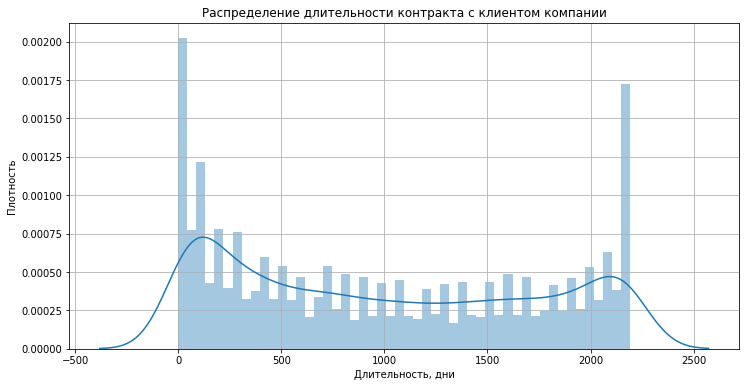

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df['Duration'], bins=50, ax=ax)
ax.set_title('Распределение длительности контракта с клиентом компании')
ax.grid()
ax.set_xlabel("Длительность, дни")
ax.set_ylabel("Плотность")
plt.show()

### Оценка мультиколлинеарности

Построим графики попарного рассеяния

In [35]:
df_num = df[df.select_dtypes(include=['int', 'float']).columns]

In [36]:
df_num = df[df.select_dtypes(exclude=['bool']).columns]
df_num['Target'] = df['Target'].replace({True: 'ушёл', False: 'остался'})

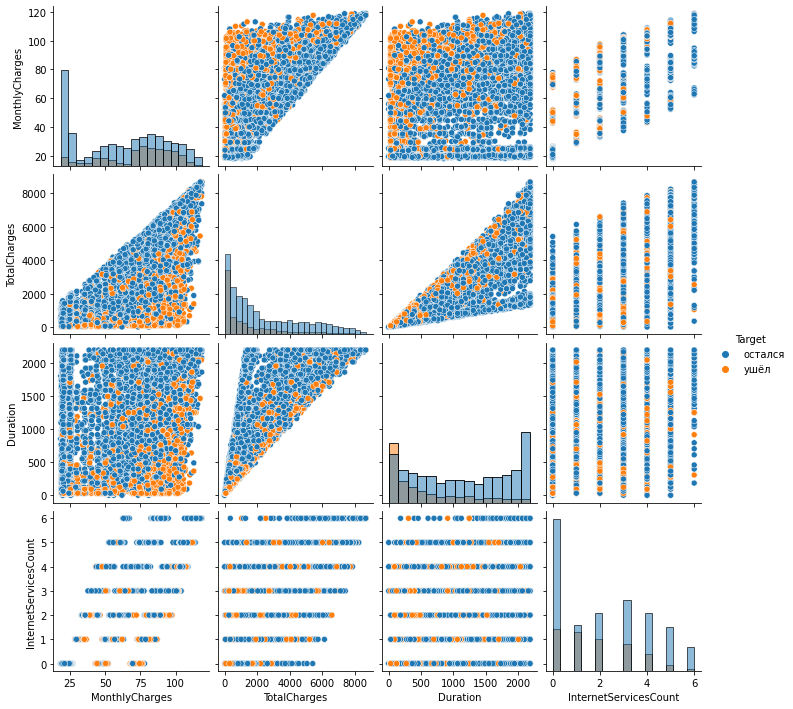

In [37]:
fig = sns.pairplot(df_num, hue='Target', diag_kind="hist")

Можно заметить сильные линейные зависимости параметров на диагонали идущей из нижнего левого угла вверх.

Рассчитаем корреляционную матрицу

In [38]:
corr_pisron = df_num[:-1].corr()
corr_spearman = df_num[:-1].corr(method='spearman')

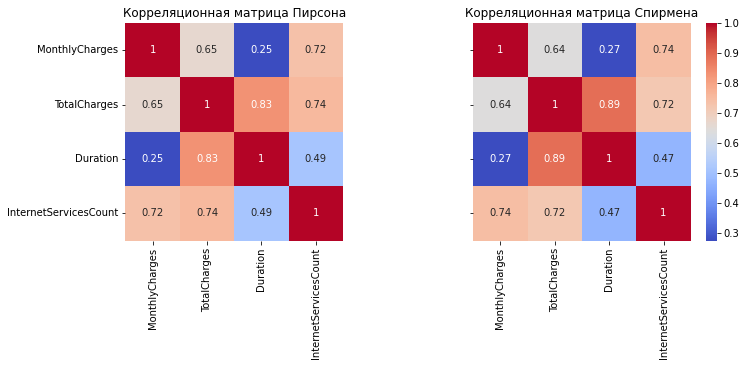

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
sns.heatmap(corr_pisron, xticklabels=corr_pisron.columns, annot = True, cmap= 'coolwarm', square=True, cbar=False, ax=ax[0])
sns.heatmap(corr_spearman, xticklabels=corr_spearman.columns, annot = True, cmap= 'coolwarm', square=True,  ax=ax[1])
ax[0].set_title('Корреляционная матрица Пирсона')
ax[1].set_title('Корреляционная матрица Спирмена')
plt.show()

In [40]:
# Корреляционная матрица Пирсона
corr_pisron.round(2) 

,MonthlyCharges,TotalCharges,Duration,InternetServicesCount
MonthlyCharges,1.00,0.65,0.25,0.72
TotalCharges,0.65,1.00,0.83,0.74
Duration,0.25,0.83,1.00,0.49
InternetServicesCount,0.72,0.74,0.49,1.00


In [41]:
# Корреляционная матрица Спирмена
corr_spearman.round(2)

,MonthlyCharges,TotalCharges,Duration,InternetServicesCount
MonthlyCharges,1.00,0.64,0.27,0.74
TotalCharges,0.64,1.00,0.89,0.72
Duration,0.27,0.89,1.00,0.47
InternetServicesCount,0.74,0.72,0.47,1.00


В таблицах чётко прослеживается сильная корреляция (0.83 и 0.89) между **Duration** и **TotalCharges**.
Величина *Duration* скорее всего требует меньше вычислений для расчёта, чем *TotalCharges*. Предлагаю оставить именно её, а вторую удалить.

In [42]:
df = df.drop(columns=['TotalCharges'])

### Разделение признаков

In [43]:
target_column = 'Target'

In [44]:
target = df[target_column].astype(int)
features = df.drop(columns=[target_column])

Разделим признаки по типам данных, для дальнейшей обработки категорий и масштабирования.

In [45]:
features_columns = list(features.columns)
cat_columns = list(features.select_dtypes(include=['object']).columns)
num_columns = list(features.select_dtypes(include=['int', 'float']).columns)

In [46]:
target_column, features_columns, cat_columns, num_columns

('Target',
 ['Type',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'Duration',
  'Gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'MultipleLines',
  'UsePhone',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'InternetServicesCount'],
 ['Type', 'PaymentMethod', 'InternetService'],
 ['MonthlyCharges', 'Duration', 'InternetServicesCount'])

### Разделение на обучающую, валидационную и тестовую выборки

Разделим выборку на обучающую, валидационную и тестовую в процентом соотношении **60:20:20**.

In [47]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)

In [48]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=42, stratify=target_valid)

In [49]:
len(df)

7043

In [50]:
len(features_train) + len(features_valid) + len(features_test), len(features_train), len(features_valid), len(features_test)

(7043, 4225, 1409, 1409)

### Обработка категориальных признаков

Заменим категории на числовые значения

In [51]:
encoder = OrdinalEncoder(dtype=int)
encoder.fit(df[cat_columns])

OrdinalEncoder(dtype=<class 'int'>)

In [52]:
features_train[cat_columns] = encoder.transform(features_train[cat_columns])
features_valid[cat_columns] = encoder.transform(features_valid[cat_columns])
features_test[cat_columns] = encoder.transform(features_test[cat_columns])

In [53]:
features_train[cat_columns] = features_train[cat_columns].astype(int)
features_valid[cat_columns] = features_valid[cat_columns].astype(int)
features_test[cat_columns] = features_test[cat_columns].astype(int)

In [54]:
features_train[cat_columns].sample(5, random_state=42)

,Type,PaymentMethod,InternetService
CustomerID,,,
0479-HMSWA,2,2,1
6257-DTAYD,2,1,1
0505-SPOOW,2,0,2
2957-JIRMN,1,2,1
4923-ADWXJ,0,0,0


### Масштабирование признаков

In [55]:
scaler = StandardScaler()
scaler.fit(features_train[num_columns])

StandardScaler()

In [56]:
features_train[num_columns] = scaler.transform(features_train[num_columns])
features_valid[num_columns] = scaler.transform(features_valid[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

In [57]:
features_train[num_columns].sample(10, random_state=42)

,MonthlyCharges,Duration,InternetServicesCount
CustomerID,,,
0479-HMSWA,1.337476,-0.261696,1.565788
6257-DTAYD,1.294603,1.567223,1.031292
0505-SPOOW,-1.487168,1.525869,-1.106691
2957-JIRMN,0.644919,1.200372,-0.572195
4923-ADWXJ,0.029862,-0.303051,0.496796
2228-BZDEE,-1.477274,0.876209,-1.106691
7025-IWFHT,0.813111,0.346609,0.496796
1474-JUWSM,0.115607,1.038957,0.496796
8920-NAVAY,1.512264,1.200372,1.565788


## Баланс классов

In [58]:
target_train.value_counts()

0    3104
1    1121
Name: Target, dtype: int64

Классы не сбалансированы. Дисбаланс небольшой. При обучении моделей попробуем в первую очередь использовать веса классов в качестве корректирующего параметра.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   7043 non-null   object 
 1   PaperlessBilling       7043 non-null   bool   
 2   PaymentMethod          7043 non-null   object 
 3   MonthlyCharges         7043 non-null   float64
 4   Target                 7043 non-null   bool   
 5   Duration               7043 non-null   int64  
 6   Gender                 7043 non-null   bool   
 7   SeniorCitizen          7043 non-null   bool   
 8   Partner                7043 non-null   bool   
 9   Dependents             7043 non-null   bool   
 10  MultipleLines          7043 non-null   bool   
 11  UsePhone               7043 non-null   bool   
 12  InternetService        7043 non-null   object 
 13  OnlineSecurity         7043 non-null   bool   
 14  OnlineBackup           7043 non-null   bool   

## Обучение моделей

В качестве эксперимента попробуем несколько моделей классификаторов разного типа, оценим метрики и скорость обучения.
Возьмём два популярных ансамбля градиентного бустинга Catboost и LightGBM, нейронную сеть на Keras, логистическую регрессию, решающие деревья и случайный лес от scikit-learn. В качестве основной метрики будем использовать AUC-ROC и дополнительно ACCURACY, PRECISION и RECALL

In [60]:
train_result_list = []

def get_model_info(name, model, features_valid, target_valid, features_test, target_test, train_time, hyper_params):
    # вычисляет метрики и собирает данные об обученной модели
    result = { 'name': None, 'roc_auc_valid': None, 'accuracy_valid': None, 
                     'precision_valid': None, 'recall_valid': None,
                     'roc_auc_test': None, 'accuracy_test': None, 
                     'precision_test': None, 'recall_test': None,
                     'train_time': None, 'hyper_params': None}
    
    result['name'] = name
    
    predictions_valid = model.predict(features_valid)
    
    result['roc_auc_valid'] = metrics.roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    result['accuracy_valid'] = metrics.accuracy_score(target_valid, predictions_valid)
    result['precision_valid'] = metrics.precision_score(target_valid, predictions_valid)
    result['recall_valid'] = metrics.recall_score(target_valid, predictions_valid)

    predictions_test = model.predict(features_test)

    result['roc_auc_test'] = metrics.roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
    result['accuracy_test'] = metrics.accuracy_score(target_test, predictions_test)
    result['precision_test'] = metrics.precision_score(target_test, predictions_test)
    result['recall_test'] = metrics.recall_score(target_test, predictions_test)
    
    result['train_time'] = train_time.seconds
    
    result['hyper_params'] = hyper_params
 
    return result

def print_model_info(model_info):
    # выводит метрики об обученной модели
    print("roc_auc_valid: {:.4f}".format(model_info['roc_auc_valid']), "roc_auc_test: {:.4f}".format(model_info['roc_auc_test']))
    print("accuracy_valid: {:.4f}".format(model_info['accuracy_valid']), "accuracy_test: {:.4f}".format(model_info['accuracy_test']))


def draw_best_features(features_names, feature_importance, feature_importance_limit=0):
    # рисует диаграмму важности признаков в модели
    df_features = pd.DataFrame(data = {'feature_name': features_names, 'importance': feature_importance})
    df_features = df_features.sort_values(by='importance', ascending=False)
    if feature_importance_limit > 0:
        df_features = df_features[df_features['importance'] > feature_importance_limit]

    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title('Диаграмма важности признаков')
    df_features.set_index('feature_name', inplace=True)
    df_features.plot.bar(ax=ax)
    ax.grid()
    fig.tight_layout()   

### LightGBM

In [61]:
hyper_params = {
    'learning_rate': 0.2,
    'class_weight': 'balanced',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'early_stopping_rounds': 25,
    'num_boost_round': 1000,
    'seed': 42,
    'verbose': -1,
    'silent': True
}

In [62]:
start_time = datetime.now()

lgb_model = lgb.LGBMClassifier(**hyper_params)
lgb_model.fit(features_train, target_train, 
              eval_set = [(features_train, target_train), (features_valid, target_valid)],
              categorical_feature = cat_columns,
              verbose= 100
             )


train_time = datetime.now() - start_time

[LightGBM] [Warning] early_stopping_round is set=25, early_stopping_rounds=25 will be ignored. Current value: early_stopping_round=25
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[38]	training's auc: 0.970678	valid_1's auc: 0.906956


In [63]:
model_info = get_model_info(type(lgb_model).__name__, lgb_model, features_valid, target_valid, features_test, target_test, train_time, hyper_params)
print_model_info(model_info)
train_result_list.append(model_info)

roc_auc_valid: 0.9070 roc_auc_test: 0.8835
accuracy_valid: 0.8197 accuracy_test: 0.8126


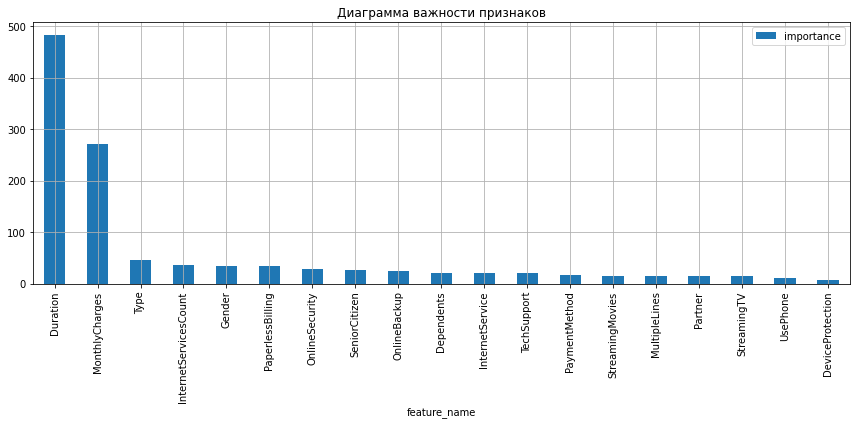

In [64]:
draw_best_features(features.columns, lgb_model.feature_importances_)

### Catboost

In [65]:
hyper_params = {
    'learning_rate': 0.1,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'AUC',
    'num_boost_round': 1000,
    'early_stopping_rounds': 25,
    'random_state': 42
}

In [66]:
start_time = datetime.now()

cb_model = cb.CatBoostClassifier(**hyper_params, thread_count=-1)
cb_model.fit(features_train, target_train, cat_features=cat_columns, eval_set=(features_valid, target_valid), 
             verbose=50)


train_time = datetime.now() - start_time

0:	test: 0.8098168	best: 0.8098168 (0)	total: 190ms	remaining: 3m 9s
50:	test: 0.8702782	best: 0.8702782 (50)	total: 1.25s	remaining: 23.3s
100:	test: 0.8812318	best: 0.8814668 (97)	total: 2.19s	remaining: 19.5s
150:	test: 0.8983583	best: 0.8983583 (150)	total: 3.23s	remaining: 18.2s
200:	test: 0.9041244	best: 0.9044705 (198)	total: 4.25s	remaining: 16.9s
250:	test: 0.9075215	best: 0.9075215 (250)	total: 5.27s	remaining: 15.7s
300:	test: 0.9134594	best: 0.9137100 (298)	total: 6.33s	remaining: 14.7s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9159342788
bestIteration = 322

Shrink model to first 323 iterations.


In [67]:
model_info = get_model_info(type(cb_model).__name__, cb_model, features_valid, target_valid, features_test, target_test, train_time, hyper_params)
print_model_info(model_info)
train_result_list.append(model_info)

roc_auc_valid: 0.9159 roc_auc_test: 0.8979
accuracy_valid: 0.8517 accuracy_test: 0.8290


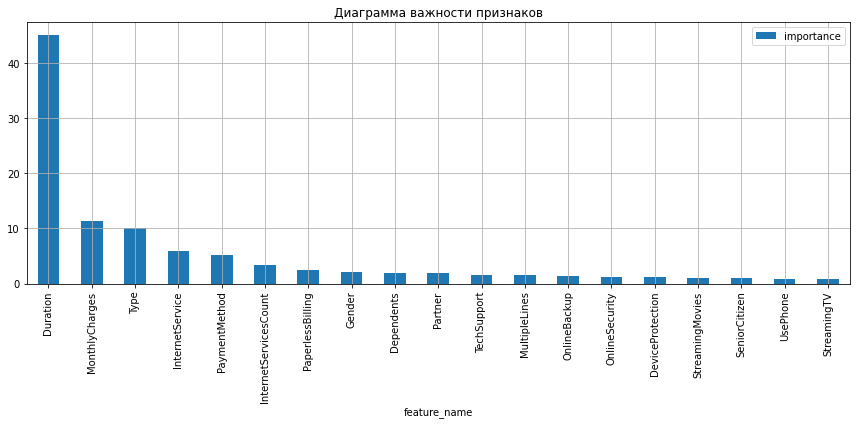

In [68]:
draw_best_features(features.columns, cb_model.feature_importances_)

### Другие модели

Для простых моделей воспользуемся методом случайного подбора гиперпараметров, как наиболее быстрым для оценки результата.

In [69]:
hyper_params_set = {
    'n_estimators':[x for x in range(10, 100, 1)],
    'max_depth': [x for x in range(4, 32, 1)], 
    'leaf_size': [x for x in range(4, 64, 1)], 
    'min_samples_leaf': [x for x in range(1, 32, 1)],
    'min_samples_split': [x for x in range(2, 32, 1)],
    'class_weight': ['balanced'],
}

In [70]:
%%time
for base_estimator in [DummyClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]:
        
    model_hyper_params = {}
    
    # подставим параметры, которые модель может принять
    for key in hyper_params_set.keys():
        if key in base_estimator.get_params().keys():
            model_hyper_params[key] = hyper_params_set[key]    
            
    # зафиксируем время старта обучения        
    start_time = datetime.now()
    
    print(type(base_estimator).__name__, '...')
    
    rs_model = RandomizedSearchCV(base_estimator, model_hyper_params, scoring='roc_auc', random_state=42, n_jobs=-1)
    rs_model = rs_model.fit(features_train, np.ravel(target_train))

    # зафиксируем время обучения        
    train_time = datetime.now() - start_time
    
    model_info = get_model_info(type(base_estimator).__name__, rs_model, 
                                features_valid, target_valid, 
                                features_test, target_test, 
                                train_time, hyper_params)
    print_model_info(model_info)
    train_result_list.append(model_info)

    print()

DummyClassifier ...
roc_auc_valid: 0.5000 roc_auc_test: 0.5000
accuracy_valid: 0.7346 accuracy_test: 0.7346

LogisticRegression ...
roc_auc_valid: 0.8552 roc_auc_test: 0.8293
accuracy_valid: 0.7402 accuracy_test: 0.7381

DecisionTreeClassifier ...
roc_auc_valid: 0.8411 roc_auc_test: 0.8341
accuracy_valid: 0.7601 accuracy_test: 0.7438

RandomForestClassifier ...
roc_auc_valid: 0.8651 roc_auc_test: 0.8410
accuracy_valid: 0.7899 accuracy_test: 0.7679

Wall time: 5.1 s


## Keras

In [71]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(target_train), y=target_train)
class_weights = dict(enumerate(class_weights))

# Early stopping
stopper = EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1)

def baseline_model():
    model = Sequential()
    model.add(keras.layers.Dense(256, input_dim=features_train.shape[1], activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')
    return model


In [72]:
start_time = datetime.now()

kc_model = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=64, verbose=1)
kc_model.fit(features_train.astype(np.float32), target_train.astype(np.float32), 
                validation_data=(features_valid.astype(np.float32), target_valid.astype(np.float32)), 
                class_weight=class_weights,
                 callbacks=[stopper],             
                shuffle=True)

train_time = datetime.now() - start_time

Epoch 1/20
67/67 [==============================] - 1s 5ms/step - loss: 0.5203 - auc: 0.8185 - val_loss: 0.4649 - val_auc: 0.8556
Epoch 2/20
67/67 [==============================] - 0s 2ms/step - loss: 0.4878 - auc: 0.8439 - val_loss: 0.4545 - val_auc: 0.8514
Epoch 3/20
67/67 [==============================] - 0s 2ms/step - loss: 0.4824 - auc: 0.8472 - val_loss: 0.5007 - val_auc: 0.8565
Epoch 4/20
67/67 [==============================] - 0s 2ms/step - loss: 0.4774 - auc: 0.8505 - val_loss: 0.4408 - val_auc: 0.8537
Epoch 5/20
67/67 [==============================] - 0s 2ms/step - loss: 0.4750 - auc: 0.8525 - val_loss: 0.4515 - val_auc: 0.8542
Epoch 6/20
67/67 [==============================] - 0s 2ms/step - loss: 0.4727 - auc: 0.8547 - val_loss: 0.4911 - val_auc: 0.8555
Epoch 00006: early stopping


In [73]:
model_info = get_model_info(type(kc_model).__name__, kc_model, features_valid.astype(np.float32), target_valid.astype(np.float32), features_test.astype(np.float32), target_test.astype(np.float32), train_time, None)
print_model_info(model_info)
train_result_list.append(model_info)

roc_auc_valid: 0.8555 roc_auc_test: 0.8298
accuracy_valid: 0.7445 accuracy_test: 0.7367


# Выводы

In [74]:
pd.DataFrame(train_result_list).sort_values(by='roc_auc_valid', 
                                            ascending=False)[['name', 
                                                              'roc_auc_valid', 'roc_auc_test', 
                                                              'accuracy_valid', 'accuracy_test',
                                                              'train_time',
                                                              'precision_valid', 'precision_test',
                                                              'recall_valid', 'recall_test']].round(4)

,name,roc_auc_valid,roc_auc_test,accuracy_valid,accuracy_test,train_time,precision_valid,precision_test,recall_valid,recall_test
1,CatBoostClassifier,0.9159,0.8979,0.8517,0.8290,8,0.6888,0.6557,0.8048,0.7487
0,LGBMClassifier,0.9070,0.8835,0.8197,0.8126,0,0.6240,0.6175,0.8075,0.7727
5,RandomForestClassifier,0.8651,0.8410,0.7899,0.7679,2,0.5819,0.5481,0.7406,0.7166
6,KerasClassifier,0.8555,0.8298,0.7445,0.7367,2,0.5118,0.5026,0.8102,0.7834
3,LogisticRegression,0.8552,0.8293,0.7402,0.7381,0,0.5067,0.5042,0.8102,0.7995
4,DecisionTreeClassifier,0.8411,0.8341,0.7601,0.7438,0,0.5327,0.5115,0.7834,0.7754
2,DummyClassifier,0.5000,0.5000,0.7346,0.7346,1,0.0000,0.0000,0.0000,0.0000


На основе предоставленных таблиц данных о пользователях мы подготовили набор признаков для обучения моделей. Данные оказались достаточно "чистыми" и без аномалий.

В качестве дополнительных признаков мы ввели "длительность контракта с пользователем" и "количество дополнительных интернет-услуг", которые рассчитали из имеющихся данных.

На этапе предобработки данных мы выявили высокую корреляцию между двумя признаками Duration и TotalCharges и приняли решение удалить последний.

В качестве моделей для обучения были выбраны:
 - LGBMClassifier, 
 - CatBoostClassifier, 
 - LogisticRegression, 
 - DecisionTreeClassifier, 
 - RandomForestClassifier, 
 - KerasClassifier
 
***Метрики***
 
Наилучший результат на валидационной выборке показал ансабль **CatBoostClassifier**:

       roc_auc = 0.92
       accuracy = 0.85
       precision = 0.69 (доля верно определённых среди тех, кто попал в прогноз на отток, 31% ошибочных)
       precision = 0.80 (доля верно определённых от искомой группы оттока, 20% из группы оттока не найдены)

Близкий по качеству, но более быстрый по скорости обучения - **LGBMClassifier**:

       roc_auc = 0.91
       accuracy = 0.82


Остальные модели разделили второе место также с приблизительно равными метриками. Для прогнозирования рекомендуется выбрать модель одного из ансамблей CatBoostClassifier или LGBMClassifier.


***Важность признаков для моделей***

Мы также проанализировали влияние признаков на результат. 

Наиболее ввесомыми для рассмотренных моделей оказались следующие:

   - Duration, 
   - MonthlyCharges, 
   - Type, 
   - InternetService, 
   - PaymentMethod, 
   - Gender,
   - InternetServicesCount.

Этим характеристикам стоит уделять больше внимания при оценке оттока клиентов.


Ряд признаков можно исключить из общего набора, оставив лишь рассчитанные дополнительные на их основе. Скорость обучения возрастёт, а метрики не изменятся. Среди слабо влияющих на метрики в первую очередь можно исключить следующие:

   - OnlineSecurity, 
   - OnlineBackup, 
   - DeviceProtection,
   - TechSupport,
   - StreamingTV,
   - StreamingMovies.
